### Audio Feature Analysis

The goal of this analysis is to 'map out' regions whose activity tracks with the RMSE of the speech soundtrack.
This script will load a variable 'resampled_audio_feature', which contains the time-varying RMSE (roughly, the sound energy) as a variable. This variable has been resampled to match the temporal resolution of fMRI (because speech is much faster). Moreover, when we correlate this audio-feature against the fmri-data, we will account for the time-delay between the sound and the fMRI response (so-called hemodynamic lag). Note that this analysis is based on simple correlations rather than a full GLM-style analysis (see Huettel, 2008). More advanced analyses (e.g. individual neutral time series regressions and GLM-style analyses,including second level testing) could also be done. The forward correlation analysis shown here is simply a more straightforward way to demonstrate the relationship between the RMSE feature and the group-level fMRI time course (and see below for individual level test).

In [1]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
sns.set_style('ticks')
%matplotlib inline

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Load relevant data

1. extracted audiofeature (RMSE)
2. extracted fMRI data

In [2]:
resampled_audio_feature = np.load('../data_itsnotthefall/01_audio_text/resampled_audio_feature_388trs.npy')
print(resampled_audio_feature.shape)

fmri_data = np.load('../data_itsnotthefall/03_extract_ts/fmri_data_itsnotthefall.npy')
print(fmri_data.shape)

(388,)
(54, 388, 268)


### Group-average the fMRI data

In [3]:
resmat_all = np.nanmean(fmri_data, axis = 0)
print(resmat_all.shape)

resmat_individual = fmri_data
print(resmat_individual.shape)

(388, 268)
(54, 388, 268)


### Correlate the time-varying audio-feature against the neural measuements (for each region)

In [4]:
res      = []
res_shuf = []
tr_shift = 3

for i in range(268):
    res.append(np.corrcoef(resmat_all[tr_shift:,i], resampled_audio_feature[:-tr_shift])[0,1])
    
    rf2 = resampled_audio_feature[:-tr_shift].copy()
    np.random.shuffle(rf2)
    res_shuf.append(np.corrcoef(resmat_all[tr_shift:,i], rf2)[0,1])

#plt.plot(res);

print(np.argmax(res))
print(np.max(res))
print('---')
print(np.argmax(res_shuf))
print(np.max(res_shuf))

162
0.3307632483000832
---
261
0.15037673110781186


In [5]:
np.where(np.asarray(res)>0.15)

(array([ 39,  60,  61, 162, 172, 179, 180]),)

In [6]:
res[60]

0.330748917197126

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


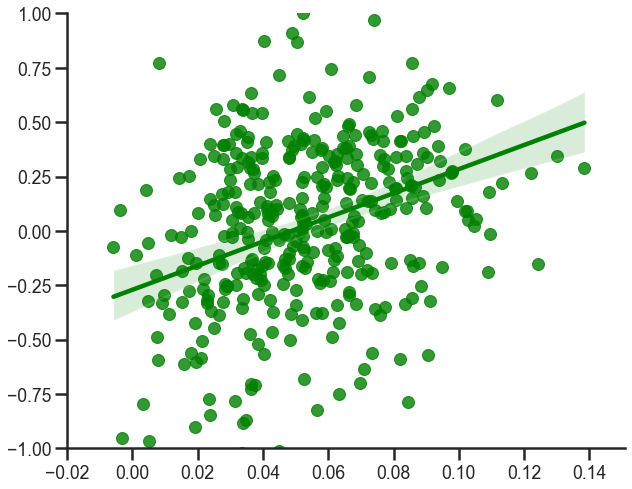

In [7]:
i = 162

sns.set_style('ticks')
plt.figure(figsize = (10, 8))
sns.regplot(
            resampled_audio_feature[:-tr_shift],
            resmat_all[tr_shift:,i], 
            color = 'Green')
plt.ylim([-1,1])
plt.xlim([-0.02,0.151])

sns.despine()

44100


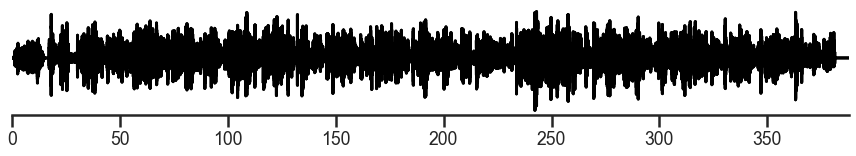

In [8]:
from scipy.io.wavfile import write

from IPython.display import Audio
from scipy.io import wavfile

sound_file = '../data_itsnotthefall/01_audio_text/itsnotthefall.wav'
samplerate, sounddata = wavfile.read(sound_file)
#print(data.shape[0]/samplerate)
print(samplerate)

plt.figure(figsize= (15,2));
plt.plot(sounddata, color ='black');
plt.xlim([0,sounddata.shape[0]]);
sns.despine(left=True);
plt.yticks([]) ;
plt.xlim([0, sounddata.shape[0]]);
plt.xticks(np.arange(0,sounddata.shape[0]+1, 75*samplerate), np.arange(0,351,50));
#plt.xticklabels(np.arange(0,450,50));


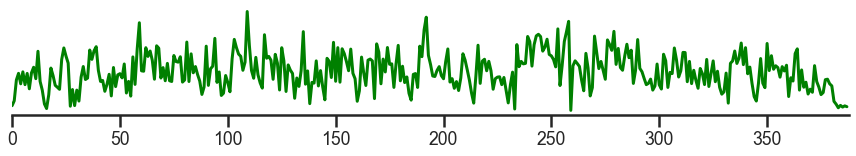

In [9]:
plt.figure(figsize= (15,2));

plt.plot(resampled_audio_feature, color = 'green')
sns.despine(left=True);
plt.yticks([]) ;
plt.xlim([0,388]);

#plt.xticklabels(np.arange(0,450,50));

### Load the brain parcellation to visualize the results

In [10]:
shen_file       = '../data_itsnotthefall/02_rois_masks_maps/shen_2mm_268_parcellation.nii'
#nilearn.plotting.plot_roi(shen_file,  cmap = 'prism',);
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);

sample_file = '../data_itsnotthefall/02_rois_masks_maps/func.nii'
shen_masker.fit_transform(sample_file);

### Threshold the results and visualize: Which brain regions track with the audio-feature?

(1, 268)
(1, 268)


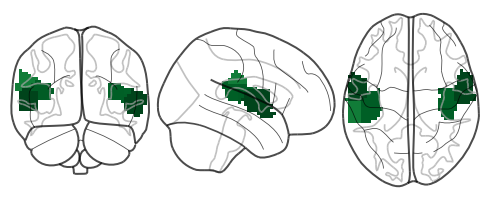

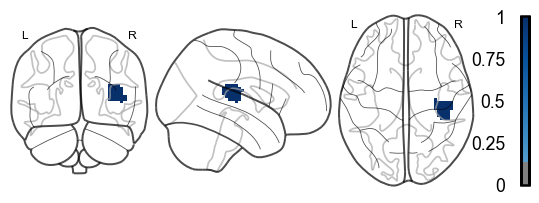

In [11]:
res = np.asarray(res)
res[res < 0.1] = 0

r2 = np.reshape(res, (1,268))
print(r2.shape)

res_img = shen_masker.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=False, 
                          annotate = False,
                          cmap="Greens", 
                          threshold=0.15,
                          plot_abs=False, 
                         );

r2       = np.zeros((1,268))
r2[0,61] = 1
print(r2.shape)

res_img  = shen_masker.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=True, 
                          annotate = True,
                          cmap="Blues", 
                          threshold=0.15,
                          plot_abs=False, 
                         );

### the shuffled results (for double checking)

(1, 268)
(1, 268)


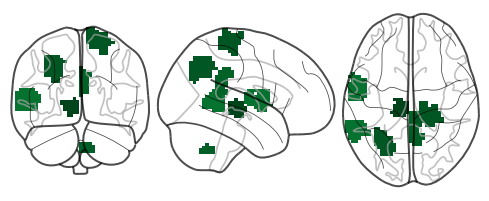

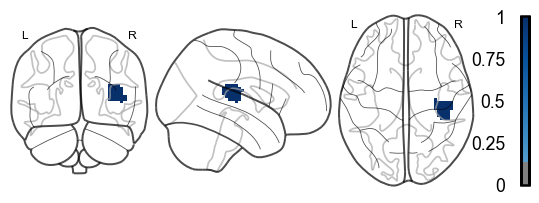

In [12]:
res_shuf = np.asarray(res_shuf)
res_shuf[res_shuf < 0.1] = 0

r2_shuf = np.reshape(res_shuf, (1,268))
print(r2_shuf.shape)

res_shuf_img = shen_masker.inverse_transform(r2_shuf);
plotting.plot_glass_brain(nilearn.image.index_img(res_shuf_img,0), 
                          colorbar=False, 
                          annotate = False,
                          cmap="Greens", 
                          #threshold=0.15,
                          plot_abs=False, 
                         );

r2_shuf       = np.zeros((1,268))
r2_shuf[0,61] = 1
print(r2_shuf.shape)

res_shuf_img  = shen_masker.inverse_transform(r2_shuf);
plotting.plot_glass_brain(nilearn.image.index_img(res_shuf_img,0), 
                          colorbar=True, 
                          annotate = True,
                          cmap="Blues", 
                          threshold=0.15,
                          plot_abs=False, 
                         );

### For comparison: Brain regions involved in "all things auditory" (from NeuroSynth.org)

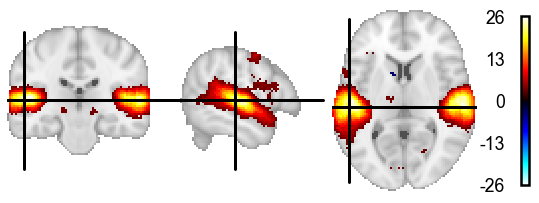

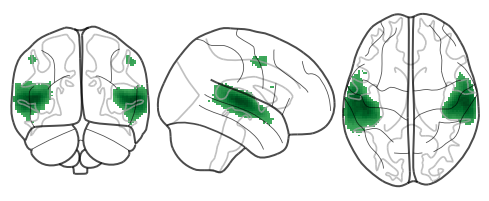

In [13]:
plotting.plot_stat_map('../data_itsnotthefall/02_rois_masks_maps/auditory_association-test_z_FDR_0.01.nii.gz', 
                          colorbar=True, 
                          annotate = False,
                         );

plotting.plot_glass_brain('../data_itsnotthefall/02_rois_masks_maps/auditory_association-test_z_FDR_0.01.nii.gz', 
                          colorbar=False, 
                          cmap = 'Greens',
                          annotate = False,
                          threshold=6.15,
                          plot_abs=True, 
                         );

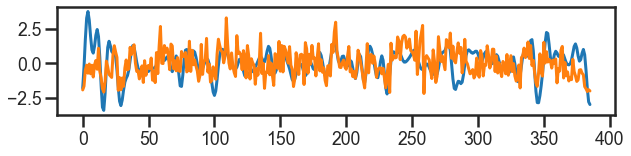

In [14]:
from scipy.stats import zscore
plt.figure(figsize = (10,2))
plt.plot(zscore(resmat_all[2:,162]));
plt.plot(zscore(resampled_audio_feature[:-2]));

### Individual-level

(here done only for reg 61, A1+, for brevity)

In [15]:
res      = []
n_subs   = resmat_individual.shape[0]
n_shuf   = 100
res_shuf = np.zeros((n_subs, n_shuf))

for curr_sub in range(n_subs):
    res.append(np.corrcoef(resmat_individual[curr_sub, tr_shift:, i], resampled_audio_feature[:-tr_shift])[0,1])
    
    for curr_shuf in range(n_shuf):
    
        rf = resampled_audio_feature[:-tr_shift].copy()
        np.random.shuffle(rf)
        res_shuf[curr_sub, curr_shuf] = np.corrcoef(resmat_individual[curr_sub, tr_shift:, i], rf)[0,1]

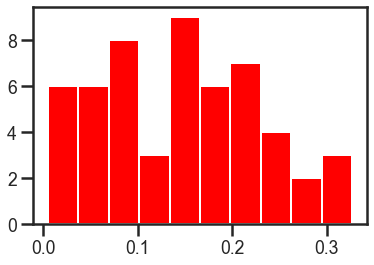

Ttest_1sampResult(statistic=12.904963155864442, pvalue=5.477373414952481e-18)
0.14725014356592517


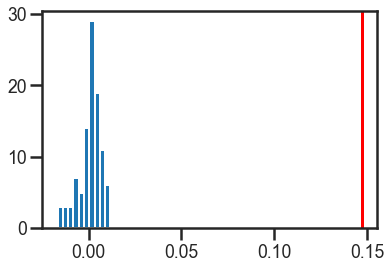

In [16]:
plt.hist(res, color='r')
plt.show()

from scipy import stats
print(stats.ttest_1samp(res, 0))

print(np.mean(res))

res_shuf1 = np.mean(res_shuf, axis=0)
plt.hist(res_shuf1);
plt.axvline(np.mean(res), color = 'red');